## Introduction

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

1. CRIM - per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 doller
11. PTRATIO: pupil-teacher ratio by town 
12. B: (1000(Bk−0.63)2) where Bk is the proportion of blacks by  
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000 doller

**In this we have to create a machine learning model to predict `MEDV` from the given data.**

## Importing Libraries

In [243]:
#autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from functools import partial

from sklearn.metrics.pairwise import rbf_kernel
from Aggregation_penalise_covariance import Agregator

In [245]:
np.random.seed(2)

## Load Model

In [246]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('../data_driven_aggregation/housing.csv', header=None, delimiter=r"\s+", names=columns)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


## Features and predicter variable

In [247]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = df.loc[:,features]
y = df['MEDV']

In [248]:
#normalize features
X = (X - X.mean()) / X.std()

In [249]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_reduced, X_val, y_train_reduced, y_val = train_test_split(X_train, y_train, test_size=0.15)

## Model Selection/Creation 

In [250]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

## Model Training and testing

In [251]:
# Define a dictionary to store the model performances
performances = {}

# Train the models and evaluate their performances
for model, name in zip(models, model_names):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances[name] = [mae, mse, r2]

## Performance visualization

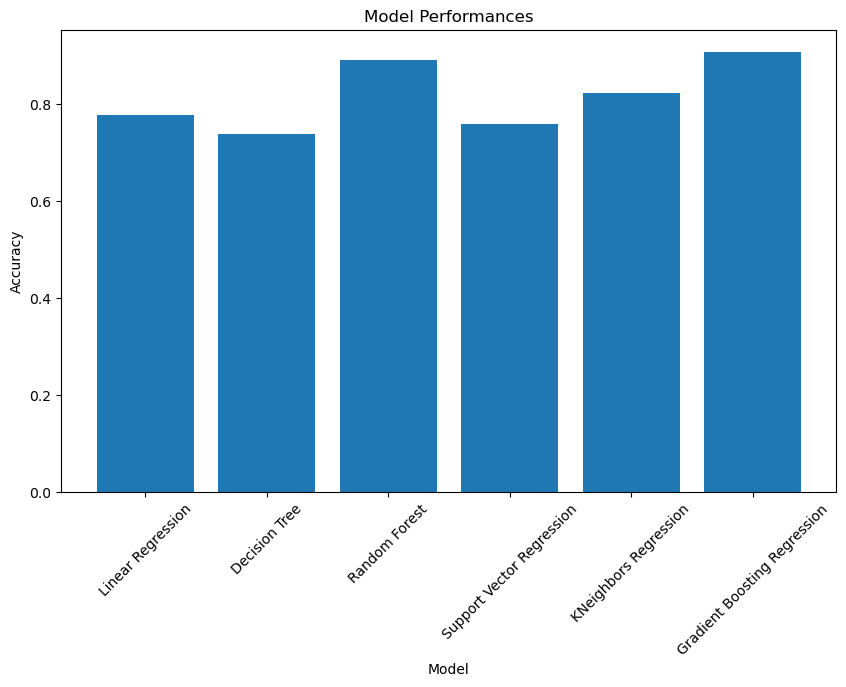

In [252]:
# Visualize the performances
plt.figure(figsize=(10, 6))
plt.bar(performances.keys(), [p[2] for p in performances.values()])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performances')
plt.xticks(rotation=45)
plt.show()

# Gaussian aggregation

In [253]:
models_reduced=[LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]
model_number=len(models_reduced)
models_reduced=[m.fit(X_train_reduced.to_numpy(),y_train_reduced.to_numpy()) for m in models_reduced]

In [254]:
ratio=0.5
model_values=np.stack(list(map(lambda x: x.predict(X_test.to_numpy()),models_reduced)),axis=0)
correlations=np.corrcoef(model_values-y_test.to_numpy()[None,:])
constant_mat=(1-ratio)*np.eye(model_number)+ratio*correlations
constant_mat

array([[1.        , 0.20364405, 0.24242116, 0.31448136, 0.28608142,
        0.23760402],
       [0.20364405, 1.        , 0.34562323, 0.19203736, 0.20617441,
        0.29488058],
       [0.24242116, 0.34562323, 1.        , 0.28386336, 0.24142918,
        0.43097938],
       [0.31448136, 0.19203736, 0.28386336, 1.        , 0.34691493,
        0.27463693],
       [0.28608142, 0.20617441, 0.24142918, 0.34691493, 1.        ,
        0.23247017],
       [0.23760402, 0.29488058, 0.43097938, 0.27463693, 0.23247017,
        1.        ]])

In [255]:
lengthscales=X_train.to_numpy()[:,None,:]-X_train.to_numpy()[None,:,:]
lengthscales=np.mean(np.abs(lengthscales),axis=(0,1))
lengthscales

array([0.64209966, 0.74222662, 1.13008384, 0.52465402, 1.10455361,
       1.04829515, 1.1000282 , 1.08922009, 0.96818239, 1.08022836,
       1.05451039, 0.75500245, 1.0887643 ])

In [256]:
def linear_separable_kernel(x,y,mat,l=None):
    K=x@y.T+1
    return K[:,:,None,None]*mat[None,None,:,:]

def gaussian_separable_kernel(x,y,mat,l):
    distances=(x[:,None,:]-y[None,:,:])/l[None,None,:]
    K=np.exp(-np.sum(np.square(distances),axis=-1)/2)+1

    return K[:,:,None,None]*mat[None,None,:,:]

    


In [258]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
import numpy as np
from tqdm.notebook import tqdm
rng = np.random.RandomState(0)
discretization=4
param_grid = {
    'kernel':['linear','gaussian'],
    'lengthscale_array': ['ones','lengthscales'],
    'lengthscale_multiplier':np.logspace(-1,0.5,discretization),
    'constant_mat_ratio':np.linspace(0,1,discretization,endpoint=True),
    'alpha':np.logspace(-3,3,discretization),
    'cov_regularizer':np.logspace(-3,3,discretization)
    }
kernel={
    'linear':linear_separable_kernel,
    'gaussian':gaussian_separable_kernel
}
lengthscale_array={
    'ones':np.ones(X.shape[1]),
    'lengthscales':lengthscales
}

max_iter=np.prod([len(param_grid[key]) for key in param_grid.keys()])
chosen_iter=1024
res=[]
sampler=ParameterSampler(param_grid, n_iter=min(chosen_iter,max_iter),random_state=rng)
for param in tqdm(sampler):
    res.append({})
    res[-1].update(param)
    mat=param['constant_mat_ratio']*np.eye(model_number)+(1-param['constant_mat_ratio'])*correlations
    my_kernel=partial(kernel[param['kernel']],mat=mat,l=param['lengthscale_multiplier']*lengthscale_array[param['lengthscale_array']])
    my_aggregate=Agregator(K=my_kernel,models=models_reduced,kernel_name=param['kernel'],intercept_choice='fit')
    my_aggregate=my_aggregate.fit(
        np.concatenate([X_val.to_numpy(),X_train_reduced.to_numpy()]),
        np.concatenate([y_val.to_numpy(),y_train_reduced.to_numpy()]),
        is_unseen=np.concatenate([np.ones(X_val.shape[0]),np.zeros(X_train_reduced.shape[0])]).astype(bool),
        alpha=param['alpha'],
        cov_regularizer=param['cov_regularizer'])
    pred = my_aggregate.predict(X_test.to_numpy())

    # Calculate the performance metrics
    res[-1]['mae']=mean_absolute_error(y_test, pred)
    res[-1]['mse']=mean_squared_error(y_test, pred)
    res[-1]['r2']=r2_score(y_test, pred)
    pd.DataFrame(res).to_csv('results.csv',index=False)


  0%|          | 0/1024 [00:00<?, ?it/s]

In [259]:
best_param=dict(pd.read_csv('results.csv').sort_values(by='r2',ascending=False).iloc[0])
best_param

{'lengthscale_multiplier': 1.0,
 'lengthscale_array': 'ones',
 'kernel': 'gaussian',
 'cov_regularizer': 10.0,
 'constant_mat_ratio': 0.0,
 'alpha': 0.1,
 'mae': 1.8572577453129373,
 'mse': 6.449348646322112,
 'r2': 0.9229097158456316}

In [260]:
mat=best_param['constant_mat_ratio']*np.eye(model_number)+(1-best_param['constant_mat_ratio'])*correlations
my_kernel=partial(kernel[best_param['kernel']],mat=mat,l=best_param['lengthscale_multiplier']*lengthscale_array[best_param['lengthscale_array']])
aggregate=Agregator(K=my_kernel,models=models_reduced,kernel_name=best_param['kernel'],intercept_choice='fit')
aggregate=aggregate.fit(
    np.concatenate([X_val.to_numpy(),X_train_reduced.to_numpy()]),
    np.concatenate([y_val.to_numpy(),y_train_reduced.to_numpy()]),
    is_unseen=np.concatenate([np.ones(X_val.shape[0]),np.zeros(X_train_reduced.shape[0])]).astype(bool),
    alpha=best_param['alpha'],
    cov_regularizer=best_param['cov_regularizer'])

In [261]:
y_pred = aggregate.predict(X_test.to_numpy())

# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store the performance metrics in the dictionary
performances['aggregation'] = [mae, mse, r2]

In [262]:
performances_reduced = {}

# Train the models and evaluate their performances
for model, name in zip(models_reduced, model_names):
    
    # Make predictions on the test set
    y_pred = model.predict(X_test.to_numpy())
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances_reduced[name] = [mae, mse, r2]

In [263]:
performances_reduced

{'Linear Regression': [3.147884201674922,
  18.96006672180041,
  0.7733667364993658],
 'Decision Tree': [3.273529411764705, 17.919901960784312, 0.785800022617309],
 'Random Forest': [2.1390784313725475, 7.838518470588226, 0.9063047061982744],
 'Support Vector Regression': [3.1881041834004704,
  22.95813563039005,
  0.725577062668089],
 'KNeighbors Regression': [3.037450980392156,
  19.704709803921567,
  0.7644658769021659],
 'Gradient Boosting Regression': [2.0651370590139946,
  7.392064114215924,
  0.9116412595592598]}

In [264]:
performances

{'Linear Regression': [3.1130437468934202,
  18.495420122448373,
  0.778920745181442],
 'Decision Tree': [3.3627450980392153, 21.772156862745092, 0.7397532911855124],
 'Random Forest': [2.131911764705882, 9.142337637254895, 0.8907199091038323],
 'Support Vector Regression': [2.9768403695950036,
  20.055021554475285,
  0.7602785342922729],
 'KNeighbors Regression': [2.7854901960784315,
  14.843207843137249,
  0.822576329310039],
 'Gradient Boosting Regression': [2.0560922332371736,
  7.713045682769407,
  0.9078045061621218],
 'aggregation': [1.8572577453129373, 6.449348646322112, 0.9229097158456316]}

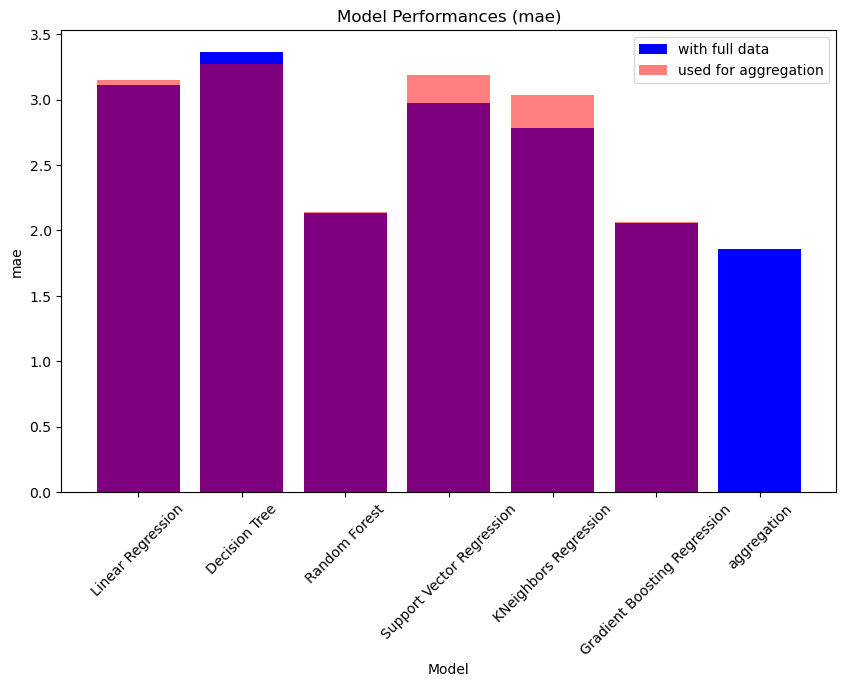

In [265]:
# Visualize the performances
which_metric={
    'mae':0,
    'mse':1,
    'r2':2
}
metric='mae'
plt.figure(figsize=(10, 6))

plt.bar(performances.keys(), [p[which_metric[metric]] for p in performances.values()],alpha=1.0,color='b',label='with full data')
plt.bar(performances_reduced.keys(), [p[which_metric[metric]] for p in performances_reduced.values()],alpha=0.5,color='r',label='used for aggregation')

#add barplot for reduced models dashed on top

plt.xlabel('Model')
plt.ylabel(metric)
plt.title(f'Model Performances ({metric})')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's see what's the best we can do? 

In [266]:
train_or_test='test'
assert train_or_test in ['train','test','val']
if train_or_test=='train':
    X_train_or_test=X_train_reduced.to_numpy()
    y_train_or_test=y_train_reduced.to_numpy()
elif train_or_test=='test':
    X_train_or_test=X_test.to_numpy()
    y_train_or_test=y_test.to_numpy()
else:
    X_train_or_test=X_val.to_numpy()
    y_train_or_test=y_val.to_numpy()


In [267]:
diffs=[]
for model, name in zip(models_reduced, model_names):
    
    # Make predictions on the test set
    y_pred = model.predict(X_train_or_test)
    diff=np.abs((y_pred-y_train_or_test))
    diffs.append(diff)
y_pred,alpha = aggregate.predict(X_train_or_test,return_alpha=True)
diff=np.abs((y_pred-y_train_or_test))
diffs.append(diff)
diffs=np.stack(diffs,axis=0)

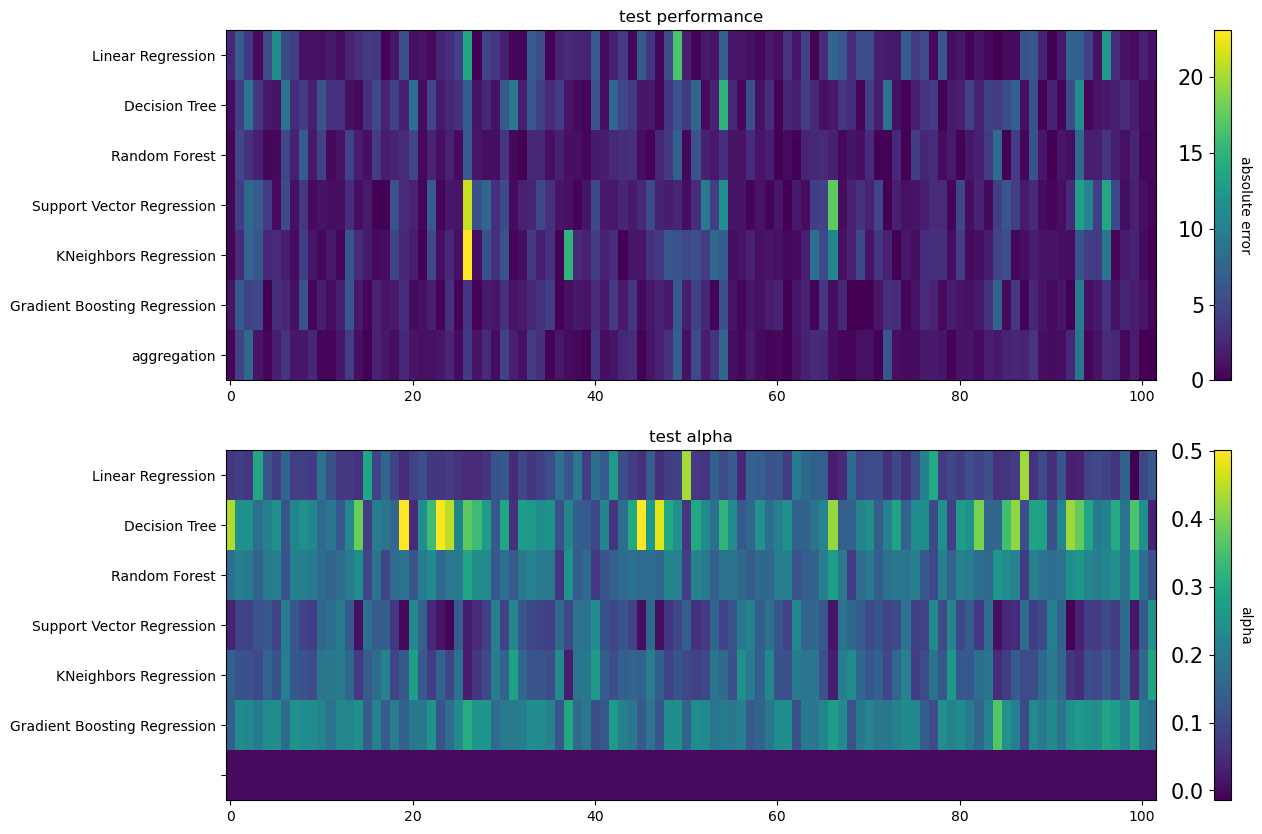

In [268]:

#change xticks labels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.imshow(np.abs(diffs), aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(np.abs(diffs), aspect='auto'))
cbar.ax.set_ylabel('absolute error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')
plt.show()

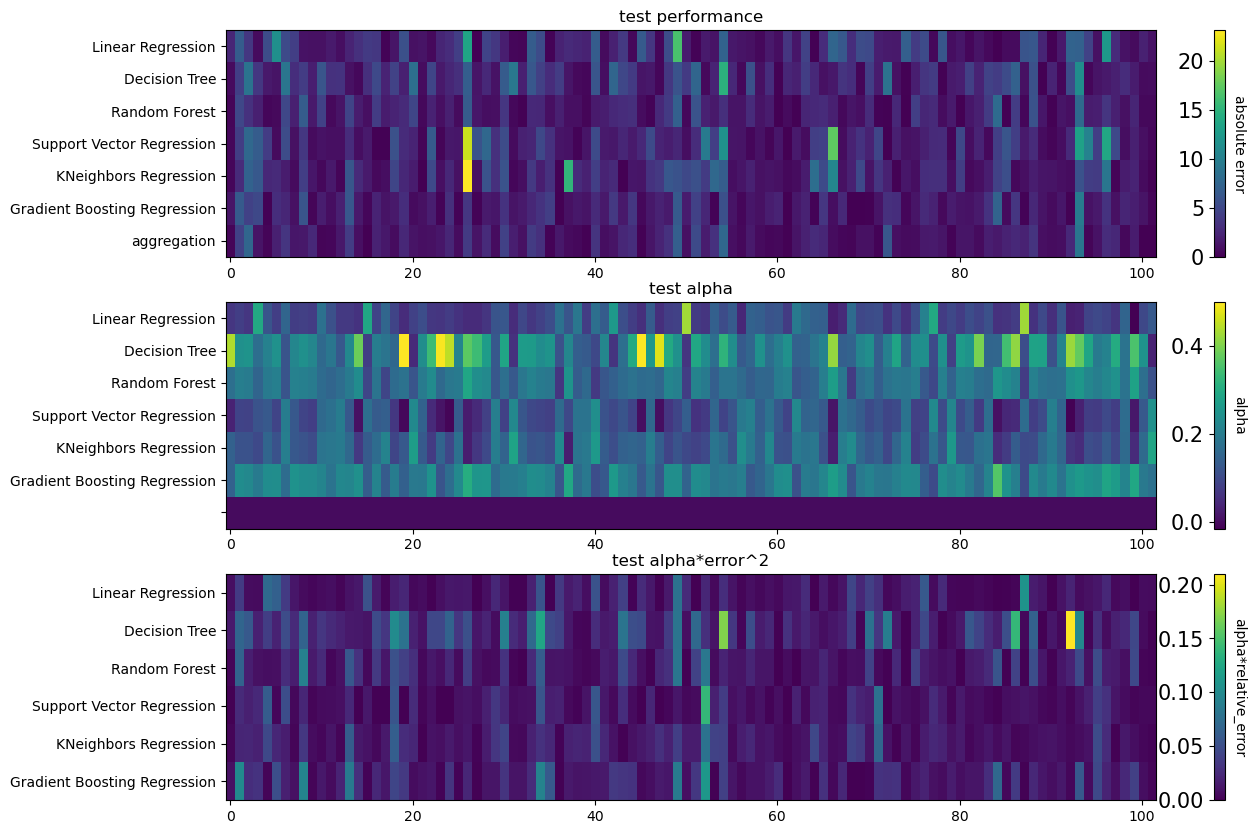

In [269]:
#same kind of plot, but add a third row with (alpha_i*diff_i)^2
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(15, 10))
ax1.imshow(np.abs(diffs), aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(np.abs(diffs), aspect='auto'))
cbar.ax.set_ylabel('absolute error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')

ax3.imshow(np.abs(alpha*diffs[:-1]), aspect='auto')
ax3.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(
    ax3.imshow(np.abs(alpha*diffs[:-1]/np.abs(y_train_or_test)[None,:]), aspect='auto'))#,norm=matplotlib.colors.LogNorm()))
cbar.ax.set_ylabel('alpha*relative_error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax3.set_title(f'{train_or_test} alpha*error^2')
plt.show()

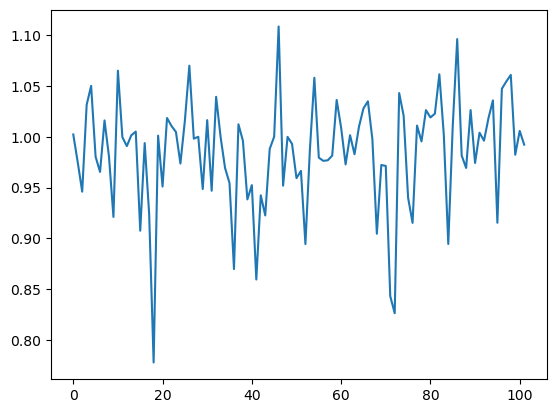

In [270]:
plt.plot(np.arange(alpha.shape[1]),np.sum(alpha,axis=0))

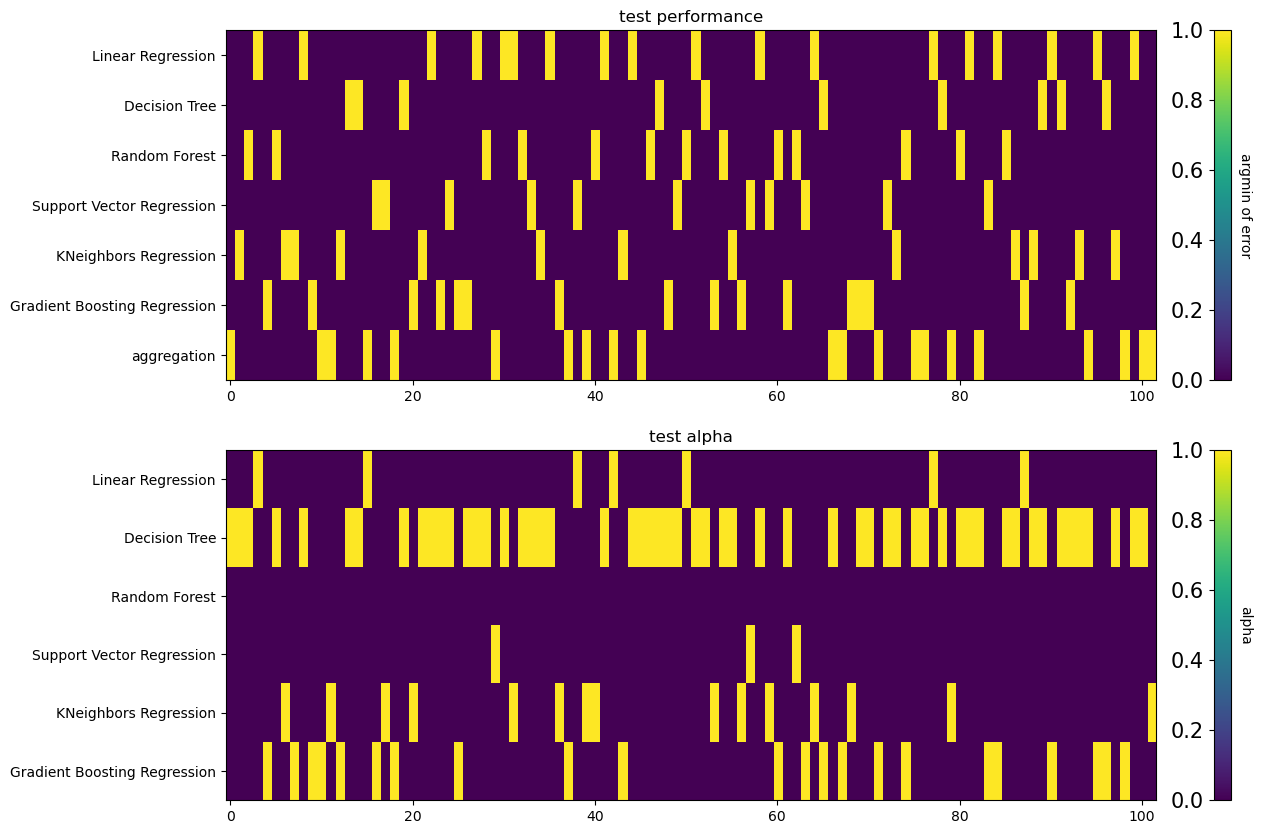

In [271]:

one_hot=np.zeros((diffs.shape[0],diffs.shape[1]))
one_hot[np.argmin(np.abs(diffs),axis=0),np.arange(diffs.shape[1])]=1
#same plot as above but with one hot encoding instead of performance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.imshow(one_hot, aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(one_hot, aspect='auto'))
cbar.ax.set_ylabel('argmin of error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
one_hot_alpha=np.zeros((alpha.shape[0],alpha.shape[1]))
one_hot_alpha[np.argmax(np.abs(alpha),axis=0),np.arange(alpha.shape[1])]=1
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(one_hot_alpha, aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(one_hot_alpha, aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')
plt.show()


In [272]:
best_model_performance=np.min(np.mean(diffs[:-1],axis=1))
print(best_model_performance)
best_possible_performance=np.mean(np.min(diffs[:-1],axis=0))
print(best_possible_performance)

2.0651370590139946
0.7632063555649998
